<a href="https://colab.research.google.com/github/Shovan-1/Python-basic/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [25]:
# Import necessary libraries
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Mount Google Drive in Colab

In [26]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Path

In [27]:
dataset_path = '/content/drive/MyDrive/Animal dataset'
categories = ['cats', 'dogs', 'panda']


Define Function to Load and Preprocess Images

In [28]:
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []  # List to store images
    labels = []  # List to store corresponding labels
    category_samples = {}  # Store one sample image per category for visualization

    print(f"Checking folder: {folder}")
    for category in os.listdir(folder):  # Iterate through subfolders (categories)
        category_path = os.path.join(folder, category)  # Path to category folder
        if os.path.isdir(category_path):  # Ensure it's a folder
            print(f"Processing category: {category}")
            for filename in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
                img_path = os.path.join(category_path, filename)  # Full image path
                img = cv2.imread(img_path)  # Load image
                if img is not None:  # If the image was loaded successfully
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                    img = cv2.resize(img, target_size)  # Resize to target size
                    images.append(img)  # Add image to list
                    labels.append(category)  # Add corresponding label

                    # Store one sample image for each category
                    if category not in category_samples:
                        category_samples[category] = img

    # If no images were loaded, notify the user
    if not images:
        print("No images were loaded. Check your dataset structure.")
        return None, None

    # Visualize one sample image from each category
    plt.figure(figsize=(15, 10))
    for i, (category, sample_img) in enumerate(category_samples.items()):
        plt.subplot(1, len(category_samples), i + 1)
        plt.imshow(sample_img, cmap='gray')  # Display grayscale image
        plt.title(category)  # Show category as title
        plt.axis('off')  # Hide axis
    plt.suptitle("Sample Images from Each Category")
    plt.show()

    return np.array(images), np.array(labels)  # Return images and labels as numpy arrays


Load and Visualize Dataset

Checking folder: /content/drive/MyDrive/Animals
Processing category: dogs


Loading dogs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing category: panda


Loading panda:   0%|          | 0/100 [00:00<?, ?it/s]

Processing category: cats


Loading cats:   0%|          | 0/100 [00:00<?, ?it/s]

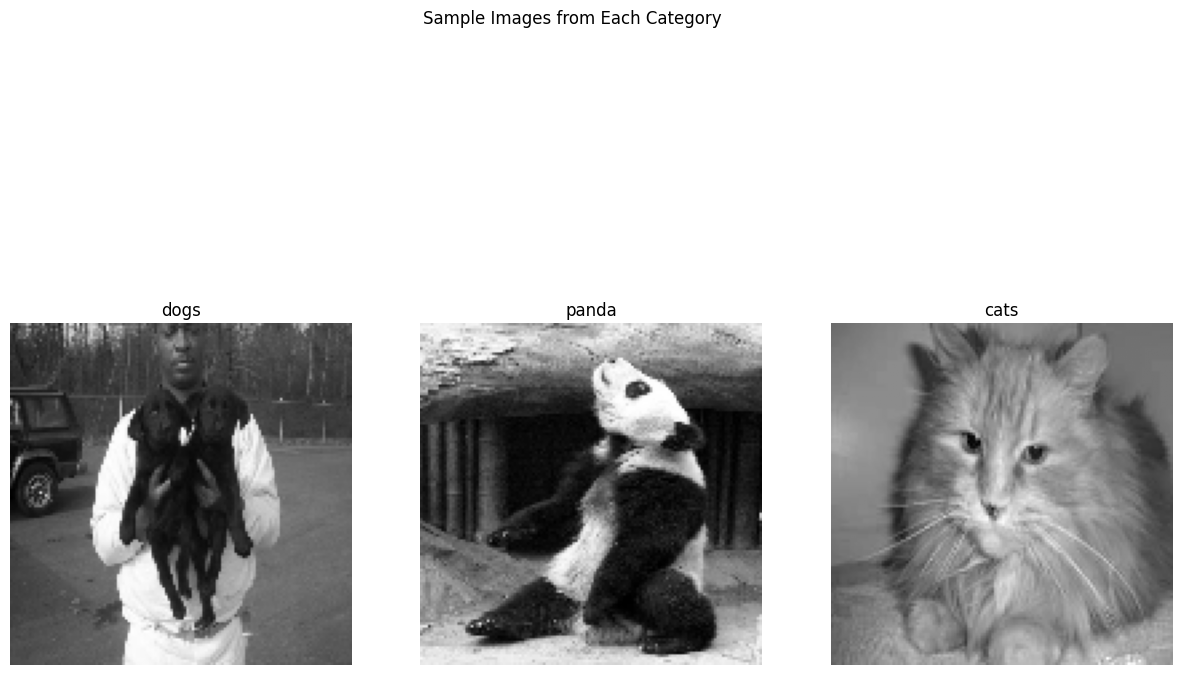

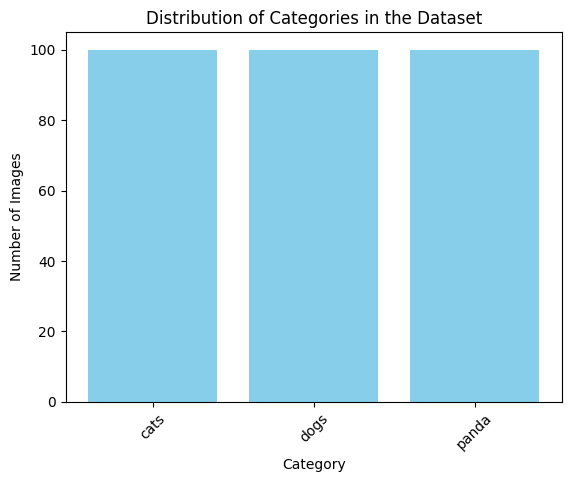

In [29]:
# Load images and their labels from the folder
images, labels = load_images_from_folder(dataset_folder, target_size=target_image_size)

# Visualize the distribution of images across categories
unique, counts = np.unique(labels, return_counts=True)  # Get category counts
plt.bar(unique, counts, color='skyblue')  # Plot a bar chart
plt.title("Distribution of Categories in the Dataset")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


Normalize and Split Dataset

In [30]:
# Normalize image pixel values to range [0, 1]
images = images / 255.0

# Split dataset into training (80%) and testing (20%) sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)


Encode Labels and Flatten Images

In [31]:
# Flatten images (convert from 2D to 1D) for k-NN
X_train_flat = train_images.reshape(train_images.shape[0], -1)
X_test_flat = test_images.reshape(test_images.shape[0], -1)

# Encode labels into integers
le = LabelEncoder()
y_train = le.fit_transform(train_labels)  # Encode training labels
y_test = le.transform(test_labels)  # Encode testing labels

# Print the shape of flattened training data
print("Flattened Image Shape:", X_train_flat.shape)


Flattened Image Shape: (240, 16384)


Define k-NN Class

In [32]:
class KNearestNeighbor:
    """
    Implements k-Nearest Neighbors (k-NN) classifier.
    """

    def train(self, X, y):
        """
        Stores training data and labels.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        """
        Predicts labels for test data using k-NN.
        """
        dists = self.compute_distances(X)  # Compute distances
        return self.predict_labels(dists, k)  # Predict labels based on distances

    def compute_distances(self, X):
        """
        Computes Euclidean distances between test and training data.
        """
        return np.sqrt((-2 * np.dot(X, self.X_train.T)) +
                       np.sum(X**2, axis=1, keepdims=True) +
                       np.sum(self.X_train**2, axis=1))

    def predict_labels(self, dists, k):
        """
        Predicts labels based on distances and nearest neighbors.
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=self.y_train.dtype)
        for i in range(num_test):  # Loop through each test sample
            k_nearest_idxs = np.argsort(dists[i])[:k]  # Indices of k nearest neighbors
            closest_y = self.y_train[k_nearest_idxs]  # Labels of nearest neighbors
            y_pred[i] = np.bincount(closest_y).argmax()  # Assign most common label
        return y_pred


Cross-Validation for k-NN

In [33]:
def cross_validate_knn(X, y, k_choices):
    """
    Perform 5-fold cross-validation for k-NN with various k values.
    """
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)  # Split into 5 folds
    k_to_accuracies = {k: [] for k in k_choices}  # Store accuracies for each k

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model = KNearestNeighbor()  # Initialize k-NN
        model.train(X_train_fold, y_train_fold)  # Train model

        print(f"\nFold {fold_idx}:")
        for k in k_choices:
            y_val_pred = model.predict(X_val_fold, k=k)  # Predict labels
            accuracy = np.mean(y_val_pred == y_val_fold)  # Calculate accuracy
            k_to_accuracies[k].append(accuracy)  # Store accuracy
            print(f"  k = {k}: Accuracy = {accuracy:.2f}")

    return k_to_accuracies


Perform Cross-Validation and Plot Results


Fold 1:
  k = 1: Accuracy = 0.38
  k = 2: Accuracy = 0.31
  k = 3: Accuracy = 0.29
  k = 4: Accuracy = 0.31
  k = 5: Accuracy = 0.33
  k = 6: Accuracy = 0.35
  k = 7: Accuracy = 0.35
  k = 8: Accuracy = 0.38
  k = 9: Accuracy = 0.31
  k = 10: Accuracy = 0.38
  k = 11: Accuracy = 0.33
  k = 12: Accuracy = 0.35
  k = 13: Accuracy = 0.40
  k = 14: Accuracy = 0.40
  k = 15: Accuracy = 0.35
  k = 16: Accuracy = 0.35
  k = 17: Accuracy = 0.40
  k = 18: Accuracy = 0.38
  k = 19: Accuracy = 0.38
  k = 20: Accuracy = 0.38
  k = 21: Accuracy = 0.40
  k = 22: Accuracy = 0.33
  k = 23: Accuracy = 0.38
  k = 24: Accuracy = 0.35
  k = 25: Accuracy = 0.38
  k = 26: Accuracy = 0.33
  k = 27: Accuracy = 0.35
  k = 28: Accuracy = 0.33
  k = 29: Accuracy = 0.42
  k = 30: Accuracy = 0.38

Fold 2:
  k = 1: Accuracy = 0.35
  k = 2: Accuracy = 0.31
  k = 3: Accuracy = 0.33
  k = 4: Accuracy = 0.33
  k = 5: Accuracy = 0.29
  k = 6: Accuracy = 0.33
  k = 7: Accuracy = 0.33
  k = 8: Accuracy = 0.38
  k = 9: Ac

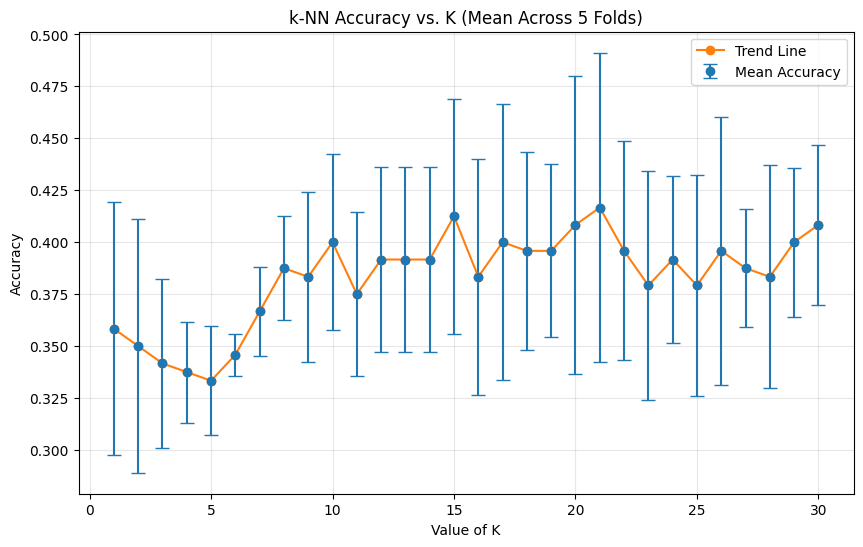

In [34]:
# Set k values to evaluate
k_choices = range(1, 31)

# Perform cross-validation
k_to_accuracies = cross_validate_knn(X_train_flat, y_train, k_choices)

# Calculate mean and standard deviation of accuracies for each k
mean_accuracies = [np.mean(k_to_accuracies[k]) for k in k_choices]
std_accuracies = [np.std(k_to_accuracies[k]) for k in k_choices]

# Plot mean accuracies with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(k_choices, mean_accuracies, yerr=std_accuracies, fmt='o', capsize=5, label="Mean Accuracy")
plt.plot(k_choices, mean_accuracies, label="Trend Line", linestyle='-', marker='o')
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.title("k-NN Accuracy vs. K (Mean Across 5 Folds)")
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.show()
